# Simulation 3
See README.md for a short description.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import constants as const
import server as srv
import agent as agn

In this implementation all the parameters of the game are defined in the *const.py* script. A *Server* has 4 ports, 5 potential vulnerable webservices it may be running, 4 potential vulnerable parameter it may receive at 2 different levels of depth.

This implies 45 possible concrete actions for the attacker.

### Random server
We define a simple function to instantiate random servers.

In [2]:
def random_server():
    vulnport = np.random.randint(0,const.N_PORTS)
    vulntype = np.random.choice(const.VULNTYPES)
    
    if(vulntype==const.VULNTYPE_ACCESSPOINT):
        vulnlevel = const.VULNLEVEL_NONE
        n = np.argmax(np.random.multinomial(1,[.5,.3,.1,.05,.05]))+1
        vulnvalue = np.random.choice(const.ACCESSPOINTS,n,replace=False)
    elif(vulntype==const.VULNTYPE_PARAM):
        vulnlevel = np.random.choice(const.VULNLEVELS)
        vulnvalue = np.random.randint(1,const.N_VULNPARAMS+1)
        
    return srv.Server(vulnport, vulnlevel, vulntype, vulnvalue)

### Creating the agent and setting the learning options 

In [3]:
agt = agn.Agent()
agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

## Simulation 3.1

We run a little number of episodes ($10$) just to observe the dynamics of the game.

In [4]:
nepisodes = 10
for _ in range(nepisodes):
    
    env = random_server()
    agt.reset(env)
    
    agt.run_episode()


HACKER: Resetting...
SERVER: Server reset
HACKER: Trying to execute exploit with param 3 on port ftp:21...
SERVER: Param Exploit Failed
HACKER: Deep reading on port ftp:21...
SERVER: DeepRead Failed
HACKER: Reading port ftp:20...
SERVER: Read Failed
HACKER: Trying to take over process Process_PID_8746 on port http:443...
SERVER: Access Attempt Failed
HACKER: Trying to take over process Process_PID_3435 on port ftp:20...
SERVER: Access Attempt Failed
HACKER: Trying to take over process Process_PID_3435 on port ftp:20...
SERVER: Access Attempt Failed
HACKER: Trying to take over process Process_PID_3435 on port ftp:20...
SERVER: Access Attempt Failed
HACKER: Trying to take over process Process_PID_42266 on port ftp:21...
SERVER: Access Attempt Failed
HACKER: Trying to take over process Process_PID_42266 on port http:80...
SERVER: Access Attempt Failed
HACKER: Trying to take over process Process_PID_8 on port http:443...
SERVER: Access Attempt Failed
HACKER: Trying to take over process Pr

## Simulation 3.2
Given the large space of states and actions we need to run a large number of episodes in order to start learning a sensible policy. 

**(Notice that this may take some minutes to run)**

**(Notice we reiniatialized the agent not to be verbose)**

In [5]:
agt = agn.Agent(verbose=False)
agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

In [6]:
steps = []
rewards = []
Qlens = []

nepisodes = 10**6
for _ in tqdm(range(nepisodes)):
    
    env = random_server()
    agt.reset(env)
    
    agt.run_episode()
    #print(len(agt.Q.keys()))
    
    steps.append(agt.steps)
    rewards.append(agt.rewards)
    Qlens.append(len(agt.Q))

100%|██████████| 1000000/1000000 [10:38<00:00, 1566.02it/s]


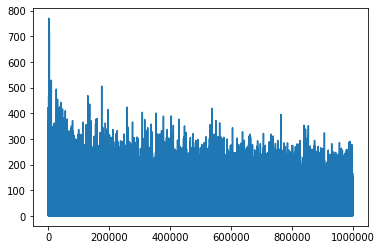

In [7]:
plt.plot(np.arange(nepisodes),steps)

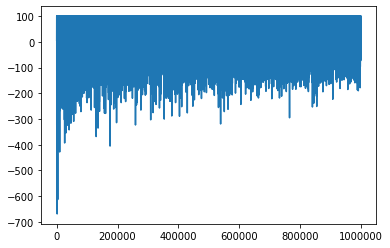

In [8]:
plt.plot(np.arange(nepisodes),rewards)

Learning takes a long time, but we notice indeed that the number of steps decrease while the amount of reward increase.

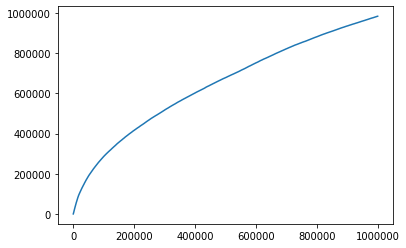

In [9]:
plt.plot(np.arange(nepisodes),Qlens)

We also observe a constant increase in the size of the Q-table (which grows exponentially at the beginning and slows down later). As new states are encountered during learning and exploration, new states are added to the Q-table. This game setting already shows the limitation of a Q-tabular approach, both in the sense of *space requirements* and in the sense of *lack of generalization*.

Yet, notice that the agent is indeed learning: if we consider the state *s1* where the agent has learned that all ports are closed except port *http:80* (port number 0) where there the service *NodeJS* (service number 2), then by far the best action is *ACCESS NodeJS on http:80* (action number 11).

In [10]:
s1 = np.zeros((const.N_PORTS, 1+const.N_ACCESSPOINTS+1),dtype='int')
s1[:,0] = const.PORT_STATE_CLOSED
s1[0,0] = const.PORT_STATE_OPEN
s1[0,3] = const.ACCESSPOINTSTATE_OPEN
agt.Q[s1.tobytes()]

array([3.12090237, 0.99543061, 4.08231167, 3.0874785 , 0.46709428,
       8.48829991, 3.27466725, 2.2214665 , 1.09858403, 0.87544661,
       3.0305225 , 2.59852211, 1.46863423, 3.66106446, 5.52417399,
       1.49317901, 4.78261604, 1.89057093, 2.23830328, 0.90094288,
       4.47926338, 4.52912767, 4.01357417, 9.73873938, 2.66066805,
       3.36721048, 2.06919321, 6.30512655, 2.61235904, 0.74220721,
       1.40917972, 7.57220495, 9.88134502, 1.82996951, 1.45253817,
       3.14938151, 5.81772517, 5.15276327, 7.72109262, 3.0584308 ,
       2.7558789 , 3.20973336, 2.67814522, 5.71911196, 4.59857809])

In [11]:
np.argmax(agt.Q[s1.tobytes()])

32

While final actions to exploit a discovered vulnerability are clear as shown above, the agent it is still far from having a clear consistent overall strategy as the Q-values for the initial state shows. At this very early point the agent has not yet learned to distinguish actions that can lead to a more rewarding course of action.

In [12]:
s1 = np.zeros((const.N_PORTS, 1+const.N_ACCESSPOINTS+1),dtype='int')
agt.Q[s1.tobytes()]

array([249.05394788, 317.99754522, 319.32154438, 552.14603717,
       301.31571741, 255.83597383, 346.03190393, 368.81317826,
       315.80386925, 243.11042566, 274.72301149, 262.77752696,
       252.54157785, 257.59580106, 256.03430479, 252.08357345,
       277.43628035, 262.66710741, 257.18929616, 359.05044459,
       310.81138938, 313.55868831, 363.32521673, 363.12880318,
       192.84858871, 239.91763759, 247.1901503 , 270.8545854 ,
       247.89019369, 410.47537018, 408.15846377, 400.60855328,
       410.00662633, 388.03798272, 413.84020157, 385.04332022,
       408.1955011 , 413.18129111, 415.43048838, 397.93575567,
       392.07859369, 399.38955326, 405.95922261, 401.96190237,
       391.62602594])

## Simulation 3.3
We run the previous simulation for $20$ times in order to collect stable statistics.

**(Notice that this may take MANY minutes to run)**

In [15]:
ntrials = 20
nepisodes = 10**5

steps = np.zeros((ntrials,nepisodes))
rewards = np.zeros((ntrials,nepisodes))
Qlens = np.zeros((ntrials,nepisodes))

for t in tqdm(range(ntrials)):
    
    agt = agn.Agent(verbose=False)
    agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

    for e in range(nepisodes):
        env = random_server()
        agt.reset(env)

        agt.run_episode()

        steps[t,e] = agt.steps
        rewards[t,e] = agt.rewards
        Qlens[t,e] = len(agt.Q)
    


100%|██████████| 20/20 [38:41<00:00, 116.06s/it]


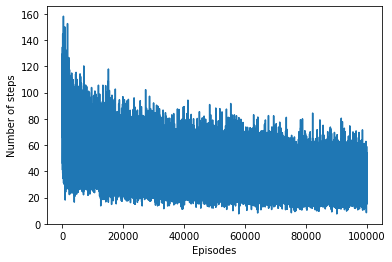

In [24]:
plt.plot(np.arange(nepisodes),np.mean(steps,axis=0))
plt.xlabel('Episodes')
plt.ylabel('Number of steps')

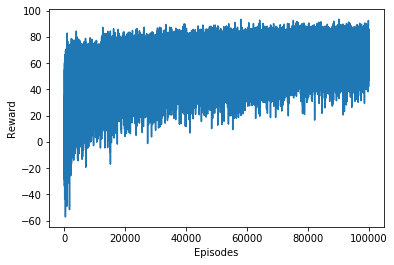

In [25]:
plt.plot(np.arange(nepisodes),np.mean(rewards,axis=0))
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.savefig('simul3_rewards.png')

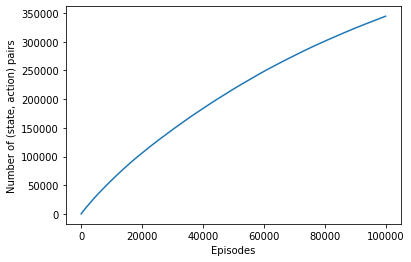

In [26]:
plt.plot(np.arange(nepisodes),np.mean(Qlens,axis=0))
plt.xlabel('Episodes')
plt.ylabel('Number of (state, action) pairs')
plt.savefig('simul3_qlens.png')